## Importing Libraries and Loading Final DataFrame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import uniform, randint
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
DF=pd.read_csv("cleaned_listings.csv")

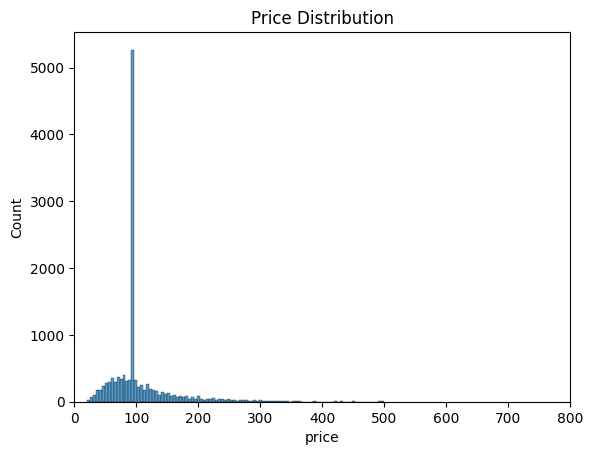

In [36]:
# Plotting the distribution of prices
# x axis limit
plt.xlim(0, 800)
sns.histplot(DF['price'], bins=100)
plt.title('Price Distribution')
plt.show()

In [ ]:

# Filter out outliers in price and apply log transform
DF = DF[(DF['price'] >= 20) & (DF['price'] <= 500)]
DF['log_price'] = np.log1p(DF['price'])

# Identify image and spatial features
image_cols = [col for col in DF.columns if col.startswith('image_feat_')]
spatial_cols = ['dist_to_center_km']  # Include your spatial feature(s) here

# Tabular columns = All except image, price, log_price
tabular_cols = [col for col in DF.columns if col not in image_cols + spatial_cols + ['price', 'log_price']]

# Combine tabular + spatial
tabular_spatial_cols = tabular_cols + spatial_cols

# Split data
X_tabular = DF[tabular_spatial_cols]
X_image = DF[image_cols]
y = DF['log_price']

X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tabular, X_image, y, test_size=0.2, random_state=42
)


In [18]:

# Select top tabular + spatial features
k_tabular = min(26, X_tab_train.shape[1])
top_tabular_selector = SelectKBest(score_func=f_regression, k=k_tabular).fit(X_tab_train, y_train)
X_tab_train_selected = top_tabular_selector.transform(X_tab_train)
X_tab_test_selected = top_tabular_selector.transform(X_tab_test)
selected_tabular_names = np.array(tabular_spatial_cols)[top_tabular_selector.get_support()]

# Scale selected tabular+spatial features
scaler_tab = StandardScaler()
X_tab_train_scaled = scaler_tab.fit_transform(X_tab_train_selected)
X_tab_test_scaled = scaler_tab.transform(X_tab_test_selected)

# Scale raw image features before PCA
scaler_img = StandardScaler()
X_img_train_scaled = scaler_img.fit_transform(X_img_train)
X_img_test_scaled = scaler_img.transform(X_img_test)

# PCA on image features (1000 components)
pca = PCA(n_components=1000, random_state=42)
X_img_train_pca = pca.fit_transform(X_img_train_scaled)
X_img_test_pca = pca.transform(X_img_test_scaled)

# Combine scaled tabular+spatial and PCA image features
X_train_combined = np.hstack([X_tab_train_scaled, X_img_train_pca])
X_test_combined = np.hstack([X_tab_test_scaled, X_img_test_pca])

# Optional: Scale the combined features before modeling (recommended)
scaler_combined = StandardScaler()
X_train_combined = scaler_combined.fit_transform(X_train_combined)
X_test_combined = scaler_combined.transform(X_test_combined)

# Feature names for DataFrame
pca_feature_names = [f"pca_image_{i}" for i in range(X_img_train_pca.shape[1])]
selected_feature_names = np.concatenate([selected_tabular_names, pca_feature_names])

X_train_df = pd.DataFrame(X_train_combined, columns=selected_feature_names)
X_test_df = pd.DataFrame(X_test_combined, columns=selected_feature_names)


### Light GBM Modelling

In [19]:

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=600, learning_rate=0.03, random_state=42)
lgb_model.fit(X_train_df, y_train)

# Predict on test set and inverse log transform
y_pred_log = lgb_model.predict(X_test_df)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# Evaluate predictions
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)
mape= np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
accuracy = 100 - mape

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}%, Accuracy: {accuracy:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256243
[LightGBM] [Info] Number of data points in the train set: 10230, number of used features: 1026
[LightGBM] [Info] Start training from score 4.579316
MAE: 21.94, RMSE: 40.44, R²: 0.495
MAPE: 21.44%, Accuracy: 78.56%


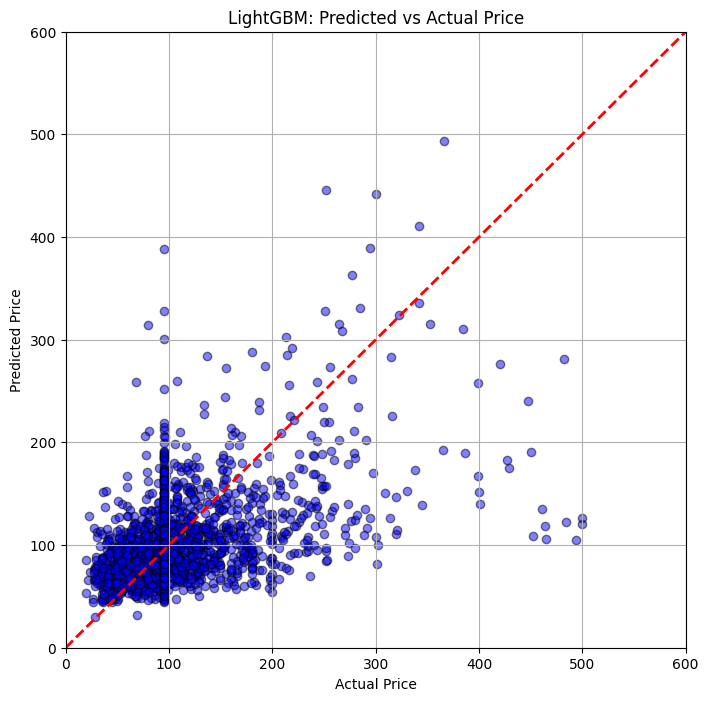

In [26]:
# Plot predicted vs actual prices for LightGBM
plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, y_pred, alpha=0.5, color='blue', edgecolors='k')
plt.plot([0, 600], [0, 600], 'r--', linewidth=2)  # line from 0 to 600
plt.xlim(0, 600)  # Fix x-axis limit
plt.ylim(0, 600)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('LightGBM: Predicted vs Actual Price')
plt.grid(True)
plt.show()


### Tunned Light GBM 

In [32]:
# from sklearn.model_selection import RandomizedSearchCV
# import lightgbm as lgb
# import numpy as np

# Define the parameter grid
param_dist = {
    'num_leaves': [20, 31, 40, 50, 60],
    'max_depth': [-1, 5, 7, 10, 12],
    'learning_rate': [0.01, 0.02, 0.03, 0.05],
    'n_estimators': [200, 400, 600, 800],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

# Set up model and random search
lgb_estimator = lgb.LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter combinations to try
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train_df, y_train)

# Best model
best_lgb_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256243
[LightGBM] [Info] Number of data points in the train set: 10230, number of used features: 1026
[LightGBM] [Info] Start training from score 4.579316
Best Params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 60, 'n_estimators': 600, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [33]:
# Predict and inverse log-transform
y_pred_log = best_lgb_model.predict(X_test_df)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# Evaluate
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
accuracy = 100 - mape

print(f"Tuned MAE: {mae:.2f}, RMSE: {rmse:.2f}, Accuracy: {accuracy:.2f}%")


Tuned MAE: 21.71, RMSE: 40.66, Accuracy: 78.83%


### Neural network model

In [22]:
model = keras.Sequential([
    layers.Input(shape=(X_train_combined.shape[1],)),  # updated input shape
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer (price prediction)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train_combined,      # use combined features
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.8136 - mae: 1.2434 - val_loss: 0.4655 - val_mae: 0.5243
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4639 - mae: 0.5297 - val_loss: 0.4404 - val_mae: 0.5359
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2744 - mae: 0.4146 - val_loss: 0.3575 - val_mae: 0.4813
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2262 - mae: 0.3743 - val_loss: 0.3263 - val_mae: 0.4500
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1840 - mae: 0.3380 - val_loss: 0.2755 - val_mae: 0.4077
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1646 - mae: 0.3176 - val_loss: 0.3032 - val_mae: 0.4391
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1452 - mae: 0.3005 - val_loss: 0.2454 - val_mae: 0.3847
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1274 - mae: 0.2808 - val_loss: 0.2658 - val_mae: 0.4103
Epoch 9/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/

In [23]:
# Predict on test set
y_pred_log = model.predict(X_test_combined).flatten()  # use combined test features

# Inverse log transform
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
accuracy = 100 - mape

# Print evaluation
print(f"Neural Network → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}%, Accuracy: {accuracy:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network → MAE: 33.14, RMSE: 52.35, R²: 0.154
MAPE: 32.24%, Accuracy: 67.76%


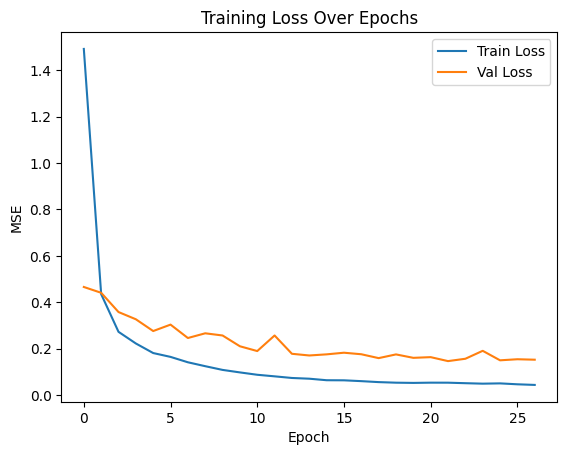

In [ ]:
# Plot training history for Neural Network
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


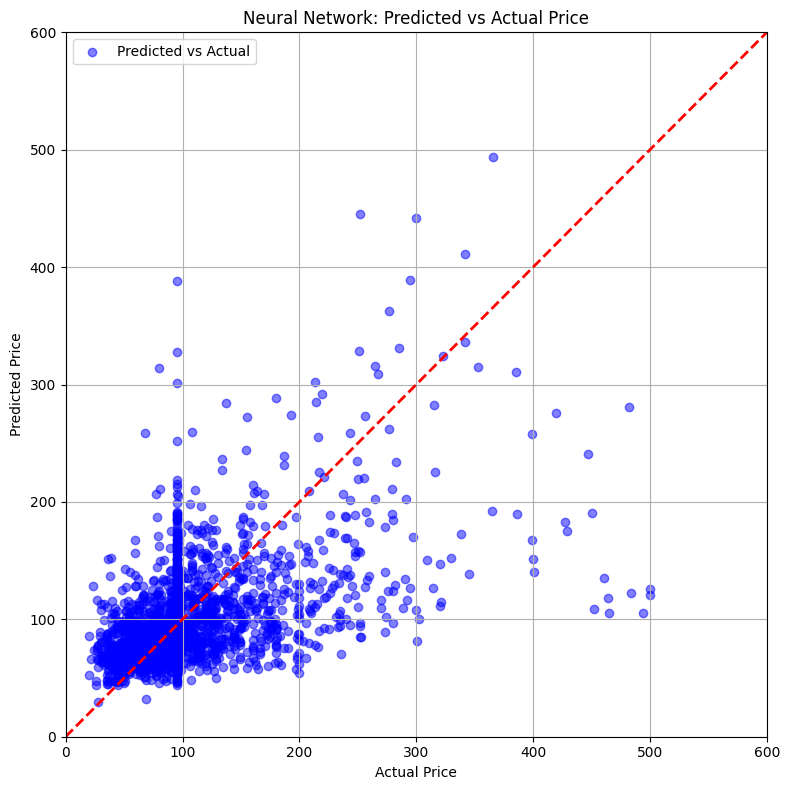

In [ ]:
# Plot predicted vs actual prices for Neural Network
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')

plt.plot([0, 600], [0, 600], 'r--', linewidth=2)  # line from 0 to 600
plt.xlim(0, 600)  # Fix x-axis limit
plt.ylim(0, 600)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Neural Network: Predicted vs Actual Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
